# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [57]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [58]:
# Load the digit data from https://www.openml.org/d/554 or from default local location `~/scikit_learn_data/...`
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape:', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape: (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

In [59]:
def draw_image(single_image):
    single_image_matrix = single_image.reshape(28,28)
    plt.gray()
    plt.imshow(single_image_matrix)

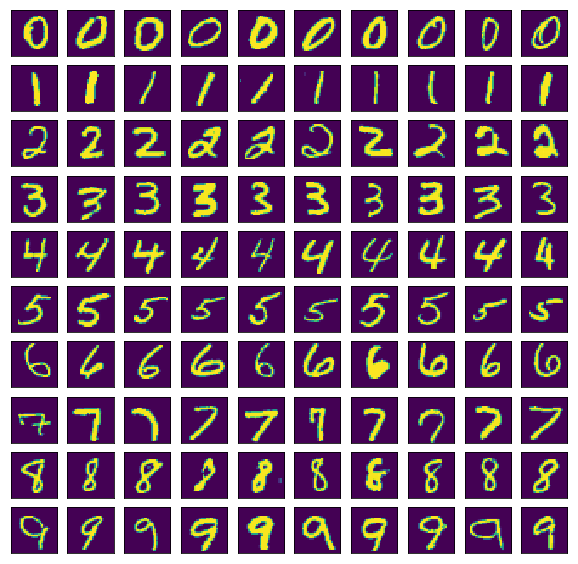

In [60]:
def P1(num_examples=10):
    rows = 10 # numbers 0-9
    columns = num_examples
    image_cell_length = 28

    fig = plt.figure(figsize=(10, 10))
    grid = plt.GridSpec(rows, columns)

    for i in range(rows):
        # Grab 10 examples of the current digit
        target_indices = np.flatnonzero(train_labels==str(i))[:num_examples]
        for j in range(columns):
            subplot = fig.add_subplot(grid[i, j])
            subplot.tick_params(
                axis='both',
                which='both',
                bottom=False,
                top=False, 
                left=False,
                right=False,
                labelbottom=False,
                labelleft=False)

            # Using the index for the label we are looking for, grab a sample vector
            image_vector_index = target_indices[j]

            # Create a matrix from the single column vector
            image_matrix = train_data[image_vector_index].reshape(image_cell_length, image_cell_length)

            # Plot the number image
            subplot.imshow(image_matrix)

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [61]:
def P2(k_values):

### STUDENT START ###
    total_count = len(dev_labels)

    # Iterate through each value for the number of neighbors to use
    for k in k_values:
        print('-----')
        # Set the number of neighbors
        model = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model using training data
        model.fit(mini_train_data, mini_train_labels)
        
        # Test the trained model
        test_predicted_labels = model.predict(dev_data)

        # Calculate the overall accuracy of the model
        correct_predictions = (test_predicted_labels == dev_labels)
        overall_accuracy = np.sum(correct_predictions) / total_count
        print(f'K value: {k} | Overall Accuracy: {overall_accuracy}')
              
        label_accuracies = {}
        min_label_accuracy = 1
        min_label = 0
        max_label_accuracy = 0
        max_label = 0
        
        # Loop through each label to find individual accuracy
        for i in range(10):
            label_indices = np.flatnonzero(dev_labels==str(i))[:]
            label_test_predictions = test_predicted_labels[label_indices]
            label_actual_values = dev_labels[label_indices]
            label_correct_predictions = (label_test_predictions == label_actual_values)
            label_accuracy = np.sum(label_correct_predictions) / len(label_indices)
            label_accuracies[i] = label_accuracy
            
            # Based on individual accuracy, set the label with the worst accuracy
            if (label_accuracy < min_label_accuracy):
                min_label_accuracy = label_accuracy
                min_label = i
            
            # Based on individual accuracy, set the label with the best accuracy
            if (label_accuracy > max_label_accuracy):
                max_label_accuracy = label_accuracy
                max_label = i
            
        print(f'Most difficult integer label: {min_label} | Accuracy: {min_label_accuracy}')
        print(f'Most accurate integer label: {max_label} | Accuracy: {max_label_accuracy}')
        
        # For only k=1, provide a classification report including precision, recall, and the f1 score
        if (k == 1):
            # F1 = 2 * (precision * recall) / (precision + recall)
            report = classification_report(test_predicted_labels, dev_labels)
            print('Classification Report for K = 1')
            print(report)
        
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

-----
K value: 1 | Overall Accuracy: 0.884
Most difficult integer label: 8 | Accuracy: 0.7659574468085106
Most accurate integer label: 1 | Accuracy: 0.9830508474576272
Classification Report for K = 1
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.98      0.89      0.93       131
           2       0.79      0.90      0.84        93
           3       0.87      0.93      0.90        90
           4       0.85      0.91      0.88        86
           5       0.88      0.86      0.87        90
           6       0.92      0.92      0.92       102
           7       0.94      0.85      0.89       113
           8       0.77      0.83      0.80        87
           9       0.86      0.80      0.83       102

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

-----
K value: 3 | Overall Accuracy: 0.87

ANSWER: The most difficult digit to classify is 2 for k values 5-9, while 8 is the most difficult digit for k = 1 and 2. 

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [62]:
def P3(train_sizes, accuracies):
    total_count = len(dev_labels)

    # Iterate through each value for the number of neighbors to use
    for train_size in train_sizes:
        
        print('-----')
        start_time = time.time();
        k = 1
        # Set the number of neighbors
        model = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model using training data
        model.fit(train_data[:train_size], train_labels[:train_size])
        
        # Test the trained model
        test_predicted_labels = model.predict(dev_data)

        # Calculate the overall accuracy of the model
        correct_predictions = (test_predicted_labels == dev_labels)
        overall_accuracy = np.sum(correct_predictions) / total_count
        
        accuracies.append(overall_accuracy)
        elapsed_time_sec = (time.time() - start_time)
        print(f'K value: {k} | Training Size: {train_size} | Overall Accuracy: {overall_accuracy} | Time Elapsed: {elapsed_time_sec} seconds')

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

-----
K value: 1 | Training Size: 100 | Overall Accuracy: 0.702 | Time Elapsed: 0.1255035400390625 seconds
-----
K value: 1 | Training Size: 200 | Overall Accuracy: 0.791 | Time Elapsed: 0.23952746391296387 seconds
-----
K value: 1 | Training Size: 400 | Overall Accuracy: 0.811 | Time Elapsed: 0.48996996879577637 seconds
-----
K value: 1 | Training Size: 800 | Overall Accuracy: 0.866 | Time Elapsed: 1.0290000438690186 seconds
-----
K value: 1 | Training Size: 1600 | Overall Accuracy: 0.905 | Time Elapsed: 2.064530611038208 seconds
-----
K value: 1 | Training Size: 3200 | Overall Accuracy: 0.927 | Time Elapsed: 4.12397027015686 seconds
-----
K value: 1 | Training Size: 6400 | Overall Accuracy: 0.939 | Time Elapsed: 8.70500135421753 seconds
-----
K value: 1 | Training Size: 12800 | Overall Accuracy: 0.952 | Time Elapsed: 17.71552872657776 seconds
-----
K value: 1 | Training Size: 25000 | Overall Accuracy: 0.962 | Time Elapsed: 35.00047326087952 seconds


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Linear Regression Formula:
 y = 0.0006838061418822407 * x + 83.44086553721631
Accuracy prediction for test training size: [124.46923405]


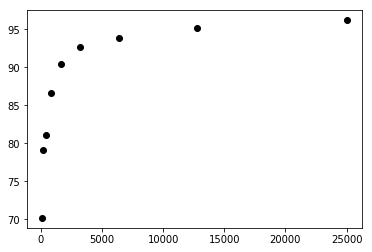




Linear Regression Formula:
 y = 4.437089824918994 * x + 54.553691279700644
Accuracy prediction for test training size: [103.37099654]


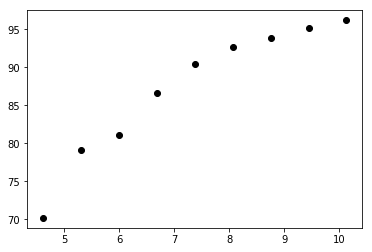

In [63]:
def plot_knn_accuracy_for_training_sizes(x_values, y_values, test_size):
    x_values = np.array(x_values).reshape(-1,1)
    reg = LinearRegression().fit(x_values, y_values)
    
    m = reg.coef_[0]
    b = reg.intercept_
    print('Linear Regression Formula:')
    print(' y = {0} * x + {1}'.format(m, b))
    plot = plt.scatter(x_values, y_values,  color='black')
    print(f'Accuracy prediction for test training size: {reg.predict(np.array([[test_size]]))}')
    return plot

def P4():
    test_train_size = 60000
    
    x_values = train_sizes
    x_values = np.array(x_values).reshape(-1,1)
    y_values = [i * 100 for i in accuracies] # Convert decimals to percentages
    
    plot1 = plot_knn_accuracy_for_training_sizes(train_sizes, y_values, test_train_size)
    plt.show(plot1)
    print()
    print()
    print()
    
    # Perform log transformation on training sizes
    x_values = [np.log(i) for i in train_sizes]
    x_values = np.array(x_values).reshape(-1,1)
    plot2 = plot_knn_accuracy_for_training_sizes(x_values, y_values, np.log(test_train_size))
    plt.show(plot2)


P4()

ANSWER: The original curve does not appear linear. Increases in the training size appear to have diminishing marginal returns and regression relies on the assumption that there is a linear relationship between variables. I transformed the x values with a log transformation to try and get a more linear looking scatterplot. Regression predicts the accuracy will be over 100% for a training set size of 60,000 without the log transformation, and this doesn't make sense as accuracy cannot go above 100%. Even with the transformation, the upper bound for predicted accuracy could still go above 100% which could be problamatic for extended use cases.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion Matrix
Predicted label shown by column index value
True label shown by row index value
[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]


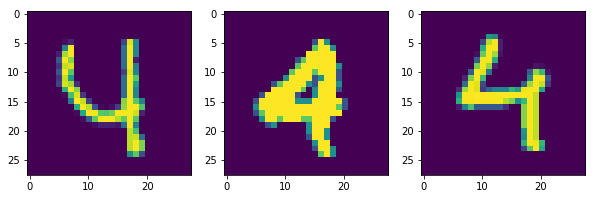

In [64]:
def P5():
    k = 1
    number_of_examples = 3

    # Set the number of neighbors
    model = KNeighborsClassifier(n_neighbors=k)

    # Fit the model using training data
    model.fit(mini_train_data, mini_train_labels)

    # Test the trained model
    test_predicted_labels = model.predict(dev_data)

    result = confusion_matrix(dev_labels, test_predicted_labels)
    print('Confusion Matrix')
    print('Predicted label shown by column index value')
    print('True label shown by row index value')
    print(result)
    
    # Most confused pair
    # Predicted 9, actual value was a 4
    # print(result[4,9])
    
    confused_prediction_indices = np.where(test_predicted_labels == '9')
    confused_true_label_indices = np.where(dev_labels == '4')
    
    sample_indices = []
    
    # Grab a few examples where we predicted 9, by the true label was 4
    for prediction in confused_prediction_indices[0]:
        if (prediction in confused_true_label_indices[0]):
            sample_indices.append(prediction)
        
        if len(sample_indices) >= number_of_examples:
            break

    # Plot the examples
    fig = plt.figure(figsize=(10, 10))
    grid = plt.GridSpec(1, number_of_examples)
    i = 0
    
    for sample_index in sample_indices:
        single_image = dev_data[sample_index]
        subplot = fig.add_subplot(grid[0,i])
        single_image_matrix = single_image.reshape(28,28)
        subplot.imshow(single_image_matrix)
        i = i + 1

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [65]:
# Takes in a two-dimensional matrix representing an image
# Combine surrounding values for a single pixel and smooth the values together
def blur_image(image_matrix, original_value_weight = .25):
    blurred_image = []
    for i in range(len(image_matrix)):
        for j in range(len(image_matrix[i])):
            current_value = image_matrix[i][j]
            surrounding_values = []
            
            isTopRow = i == 0
            isRightColumn = j == len(image_matrix[i]) - 1
            isLeftColumn = j == 0
            isBottomRow = i == len(image_matrix) - 1
            
            # top
            if  not isTopRow:
                top_value = image_matrix[i - 1][j]
                surrounding_values.append(top_value)
                
            # top-right   
            if not isTopRow and not isRightColumn:
                    top_right_value = image_matrix[i - 1][j + 1]
                    surrounding_values.append(top_right_value)           
            
            # right
            if not isRightColumn:
                right_value = image_matrix[i][j + 1]
                surrounding_values.append(right_value)
            
            # bottom-right
            if not isRightColumn and not isBottomRow:
                bottom_right_value = image_matrix[i + 1][j + 1]
                surrounding_values.append(bottom_right_value)
                
            # bottom
            if not isBottomRow:
                bottom_value = image_matrix[i + 1][j]
                surrounding_values.append(bottom_value)
                
            # bottom-left
            if not isBottomRow and not isLeftColumn:
                bottom_left_value = image_matrix[i + 1][j - 1]
                surrounding_values.append(bottom_left_value)
                
            # left
            if not isLeftColumn:
                left_value = image_matrix[i][j - 1]
                surrounding_values.append(left_value)
                
            # top left
            if not isLeftColumn and not isTopRow:
                top_left_value = image_matrix[i - 1][j - 1]
                surrounding_values.append(top_left_value)
            
            average_surrounding_value = np.average(surrounding_values)
            new_blurred_value = (original_value_weight * image_matrix[i][j]) + ((1 - original_value_weight) * average_surrounding_value)
            
            blurred_image.append(new_blurred_value)
            
    return blurred_image

# Blurs pixel values with the surrounding 8 values
# original_value_weight refers to how high a percentage the original pixel value should have when combined
# with the average of the surrounding values
def blur_images(image_data, original_value_weight = .25):
    image_cell_length = 28
    blurred_images = []
    # for each row where a row is a new image vector
    
    for image in image_data:
        image_matrix = image.reshape(image_cell_length, image_cell_length)
        blurred_image_vector = blur_image(image_matrix, original_value_weight)
        blurred_images.append(np.array(blurred_image_vector))
    
    return blurred_images
        
    

Blurred image:


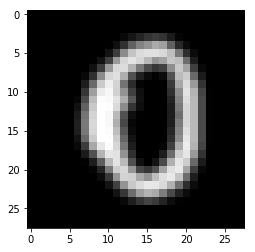

In [66]:
test = blur_images(mini_train_data)
print('Blurred image:')
draw_image(test[0])

Original image:


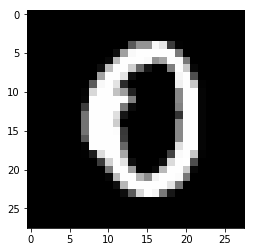

In [67]:
print('Original image:')
draw_image(mini_train_data[0])

In [68]:
def knn_test(k, training_data, training_labels, testing_data, testing_labels):
    
    # Set the number of neighbors
    model = KNeighborsClassifier(n_neighbors=k)

    # Fit the model using training data
    model.fit(training_data, training_labels)

    # Test the trained model
    test_predicted_labels = model.predict(testing_data)
    
    # Calculate the overall accuracy of the model
    total_count = len(testing_labels)
    correct_predictions = (test_predicted_labels == testing_labels)
    overall_accuracy = np.sum(correct_predictions) / total_count
    print(f'K value: {k} | Overall Accuracy: {overall_accuracy}')
        

In [69]:
def P6():

    k = 8
    
    # How much of the original pixel value should be used when combined with the averages of the surrounding pixels
    original_value_weight = .12
    
    print('----')
    print('Blurred training data and original test data:')
    knn_test(k, blur_images(mini_train_data, original_value_weight), mini_train_labels, dev_data, dev_labels)
          
    print('----')
    print('Original training data and blurred test data:')
    knn_test(k, mini_train_data, mini_train_labels, blur_images(dev_data), dev_labels)
                    
    print('----')
    print('Blurred training data and blurred test data:')
    knn_test(k, blur_images(mini_train_data), mini_train_labels, blur_images(dev_data), dev_labels)

P6()

----
Blurred training data and original test data:
K value: 8 | Overall Accuracy: 0.898
----
Original training data and blurred test data:
K value: 8 | Overall Accuracy: 0.859
----
Blurred training data and blurred test data:
K value: 8 | Overall Accuracy: 0.893


ANSWER: Of the 3 different approaches to blurring, blurring the training set creates the best accuracy. This is because blurring the data set better approximates a large training data set of possible values and examples necessary to predict each label.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [70]:
def binary_threshold_nb(training_data, training_labels, testing_data, testing_labels, threshold = .5, alpha = 1):
    clf = BernoulliNB(alpha=alpha, binarize=threshold)
    clf.fit(training_data, training_labels)
    
    score = clf.score(testing_data, testing_labels)
    
    print('---Binarized sklearn NB---')
    print(f'sklearn accuracy: {score}')

In [71]:
def bin_pixels(data):
    # Initialize a new feature array with the same shape as the original data.
    binned_data = np.zeros(data.shape)

    first_threshold = 2/3
    first_bin = 2
    
    second_threshold = 1/3
    second_bin = 1
    
    for i in range(0, len(data)):
        
        # For each pixel, bin the values depending on which theshold they fall in
        for j in range(0, len(data[i])):
            if (data[i][j] >= first_threshold):
                binned_data[i][j] = first_bin
            elif (data[i][j] >= second_threshold):
                binned_data[i][j] = second_bin
    
    return binned_data

def binned_threshold_nb(training_data, training_labels, testing_data, testing_labels, alpha = 1):
    binned_training_data = bin_pixels(training_data)
    
    alpha = .001
    clf = MultinomialNB(alpha = alpha)
    clf.fit(binned_training_data, training_labels)
    
    score = clf.score(testing_data, testing_labels)
    
    print('---Multinomial sklearn NB---')
    print(f'sklearn accuracy: {score}')


    

In [72]:
def P7():
    binary_threshold_nb(mini_train_data, mini_train_labels, dev_data, dev_labels)
    binned_threshold_nb(mini_train_data, mini_train_labels, dev_data, dev_labels)   

P7()

---Binarized sklearn NB---
sklearn accuracy: 0.819
---Multinomial sklearn NB---
sklearn accuracy: 0.814


ANSWER: The multinomial model does not improve the accuracy of the classifier. The multinomial fits in a less generalized way with more complexity, and thus does not perform as well when applied to the testing data set.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [73]:
def P8(alphas):
    binarized_threshold = .5
    clf = GridSearchCV(BernoulliNB(binarize=binarized_threshold), alphas, cv=5)
    clf.fit(mini_train_data, mini_train_labels)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = dev_labels, clf.predict(dev_data)
    print(classification_report(y_true, y_pred))
    print()

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

C:\Users\Sancho\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Sancho\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Sancho\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Sancho\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Sancho\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best parameters set found on development set:

{'alpha': 0.001}

Grid scores on development set:

0.830 (+/-0.079) for {'alpha': 0.0}
0.838 (+/-0.085) for {'alpha': 0.0001}
0.841 (+/-0.084) for {'alpha': 0.001}
0.836 (+/-0.089) for {'alpha': 0.01}
0.827 (+/-0.097) for {'alpha': 0.1}
0.825 (+/-0.085) for {'alpha': 0.5}
0.823 (+/-0.086) for {'alpha': 1.0}
0.817 (+/-0.088) for {'alpha': 2.0}
0.764 (+/-0.091) for {'alpha': 10.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       106
           1       0.92      0.93      0.92       118
           2       0.75      0.81      0.78       106
           3       0.75      0.77      0.76        97
           4       0.76      0.83      0.79        92
           5       0.82      0.73      0.77        88
           6       0.94      0.86      0.90       102
 

C:\Users\Sancho\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ANSWER: The best value for alpha is .001. 

The accuracy when alpha is 0 is .830, although scikit learn does not allow for a true zero value and instead converts it to 1.0e-10. We would expect the 0 alpha value accuracy to be smaller than a slightly larger alpha value because a lack of smoothing puts a disproportionate amount of value on a lack of examples in our training data. This can cause naive bayes to be overly confident in predictions for which it does not have enough examples. 

Too large of an alpha value, on the other hand, smoothes out the data too much to the point where we lose discrepancies between the original underlying data.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [74]:
def gaussian_nb():
    clf = GaussianNB()
    clf.fit(mini_train_data, mini_train_labels)
    
    score = clf.score(dev_data, dev_labels)

    print(f'Gaussian NB sklearn accuracy: {score}')

    return clf


gnb = gaussian_nb()

Gaussian NB sklearn accuracy: 0.593


In [75]:
def guassian_nb_fix():

    #clf = GaussianNB(var_smoothing = .06)
    clf = GaussianNB()
    clf.fit(mini_train_data, mini_train_labels)   
    
    var_min_value = 0.01
    var_increment_value = 0.01
    
    theta_min_value = 0
    theta_increment_value = .001
       
    for i in range(len(clf.sigma_)):       
        for j in range(len(clf.sigma_[i])):
            
            # if the variance is very small, add a smoothing value to account for a lack of examples in training
            if clf.sigma_[i][j] <= var_min_value:
                clf.sigma_[i][j] += var_increment_value
            
            # if the mean value for the feature is 0, add a smoothing value to account for a lack of examples in training
            if clf.theta_[i][j] == theta_min_value:
                clf.theta_[i][j] += theta_increment_value
            
    score = clf.score(dev_data, dev_labels)

    print(f'Altered Guassian NB sklearn accuracy: {score}')
    
    return clf

gnb = guassian_nb_fix()

Altered Guassian NB sklearn accuracy: 0.813


ANSWER: For features that have an incredibly small variance, if we add a small smoothing value, the accuracy of the gaussian nb model raises back towards to accuracy of the bernoulli model. The smoothing added to the variance helps to account for our training set making the model overconfident in features that are only ever 0 for a particular class. In reality, the variance should be larger to account for the fact that the training data may be missing positive features for a feature. Smoothing the variance helps our model account for examples it hasn't yet seen.

We can similarly add a small smoothing value to the mean value of each feature with the theta property, but this adds to the accuracy in a much smaller amount.

The variance/sigma smoothing approach is simpler, but similar approach to the var_smoothing parameter that can be passed in during the initialization of the guassian nb model.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

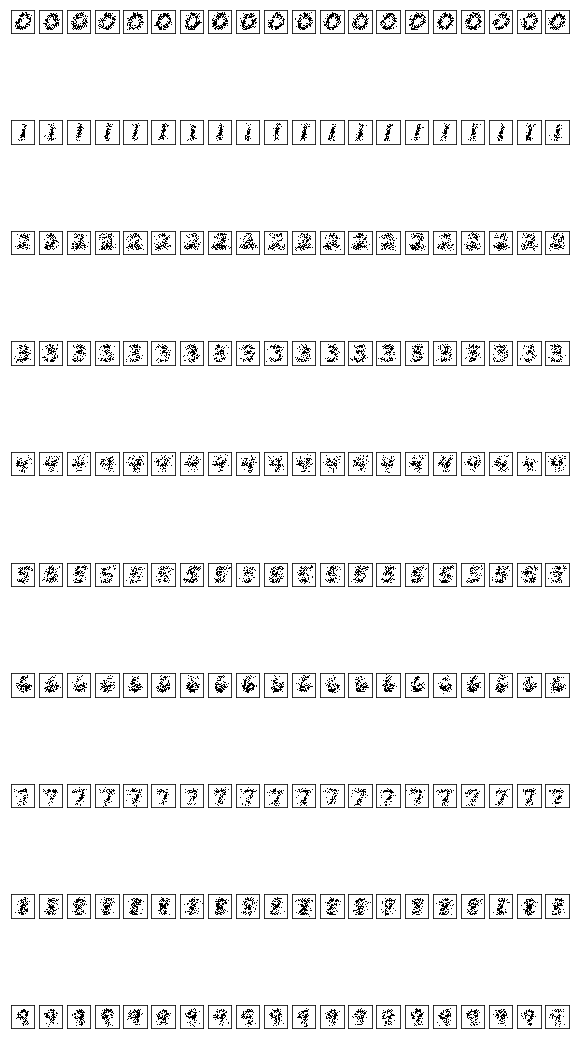

In [76]:
def P10(num_examples):
    alpha = .001
    threshold = .5
    training_data = mini_train_data
    training_labels = mini_train_labels
    
    clf = BernoulliNB(alpha=alpha, binarize=threshold)
    clf.fit(training_data, training_labels)
    
    rows = 10
    fig = plt.figure(figsize=(rows, num_examples))
    grid = plt.GridSpec(rows, num_examples)
    image_cell_length = 28
    
    for label in range(rows):
        for j in range(num_examples):
            subplot = fig.add_subplot(grid[label, j])
            subplot.tick_params(
                axis='both',
                which='both',
                bottom=False,
                top=False, 
                left=False,
                right=False,
                labelbottom=False,
                labelleft=False)

            generated_image = np.zeros(training_data[label].shape)

            for i in range(len(generated_image)):
                generated_feature_value = np.random.uniform(0,1)

                if generated_feature_value > np.exp(clf.feature_log_prob_[label][i]):
                    generated_image[i] = 1

            # Create a matrix from the single column vector
            image_matrix = generated_image.reshape(image_cell_length, image_cell_length)

            # Plot the number image
            subplot.imshow(image_matrix)
            

P10(20)

ANSWER: The generated images look similar to the real examples, but are more distorted. A combination of being binarized and having to account for the varying feature values across the training examples causes the images to look more like a clustering of dots vaugely in the shape of each digit instead of a solid line drawing like the real exmaples. The binarization removes much of the discretion in gray values that might make the generated numbers look more realistic.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  36    accuracy = 0.389
p(pred) <= 0.9990000000000    total = 126    accuracy = 0.429
p(pred) <= 0.9999900000000    total = 195    accuracy = 0.477
p(pred) <= 0.9999999000000    total = 262    accuracy = 0.527
p(pred) <= 0.9999999990000    total = 312    accuracy = 0.574
p(pred) <= 0.9999999999900    total = 384    accuracy = 0.635
p(pred) <= 0.9999999999999    total = 450    accuracy = 0.673
p(pred) <= 1.0000000000000    total = 1000    accuracy = 0.828


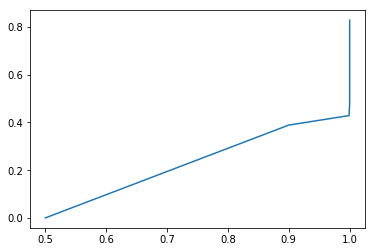

In [77]:
def P11(buckets, correct, total):
    
    alpha = .001
    threshold = .5
    training_data = mini_train_data
    training_labels = mini_train_labels
    testing_data = dev_data
    testing_labels = dev_labels
    
    clf = BernoulliNB(alpha=alpha, binarize=threshold)
    clf.fit(training_data, training_labels)
    
    for i in range(len(buckets)):
        bucket_prob = buckets[i]
        
        predictions = clf.predict_proba(testing_data)
        
        for j in range(len(testing_data)):
            
            # get the index for the label with the highest predicted probability
            best_prediction_index = np.argmax(predictions[j])
            
            # if the best prediction is less than the probability bin
            if predictions[j][best_prediction_index] <= buckets[i]:
                total[i] += 1
                if str(best_prediction_index) == testing_labels[j]:
                    correct[i] += 1

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]
accuracies = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))
    accuracies[i] = accuracy

plt.plot(buckets, accuracies)

ANSWER: The calibration level for this naive bayes model would be strongly calibrated as there is a distinct positive correlation between accuracy and bin probability.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [78]:
# Ran out of time so this is a mess... sorry!

def P12():
    alpha = .001
    threshold = .5
    training_data = mini_train_data
    training_labels = mini_train_labels
    testing_data = dev_data
    testing_labels = dev_labels
    
    clf = BernoulliNB(alpha=alpha, binarize=threshold)
    clf.fit(training_data, training_labels)
    
    
    
    score = clf.score(testing_data, testing_labels)
    
    print('---Base Binarized sklearn NB---')
    print(f'Accuracy: {score}')

P12()

#Continued below

---Base Binarized sklearn NB---
Accuracy: 0.828


In [128]:
clf = GaussianNB(var_smoothing = .15)
clf.fit(mini_train_data, mini_train_labels)   

score = clf.score(dev_data, dev_labels)

print(f'Base Guassian NB sklearn accuracy: {score}')

Base Guassian NB sklearn accuracy: 0.813


In [129]:
from sklearn import preprocessing

training_data = preprocessing.binarize(mini_train_data, threshold = .5)
training_labels = mini_train_labels
testing_data = dev_data
testing_labels = dev_labels

image_cell_length = 28

# Calculate the average number of pixels used for each digit
def get_average_pixel_counts_for_labels():
    total_pixel_counts = [[] for i in range(10)]
    average_pixel_counts = [0 for i in range(10)]

    for example_index in range(len(training_data)):
        sum_of_pixels = np.sum(training_data[example_index])
        total_pixel_counts[int(training_labels[example_index])].append(sum_of_pixels)

    for i in range(len(average_pixel_counts)):
        average_pixel_counts[i] = np.average(total_pixel_counts[i])
        print(f'Average pixel count for digit {i}: {average_pixel_counts[i]}')

    return average_pixel_counts

average_pixel_counts = get_average_pixel_counts_for_labels()

    

Average pixel count for digit 0: 137.04395604395606
Average pixel count for digit 1: 61.84375
Average pixel count for digit 2: 120.20879120879121
Average pixel count for digit 3: 111.67961165048544
Average pixel count for digit 4: 95.24742268041237
Average pixel count for digit 5: 104.96428571428571
Average pixel count for digit 6: 110.31132075471699
Average pixel count for digit 7: 88.41379310344827
Average pixel count for digit 8: 116.21138211382114
Average pixel count for digit 9: 102.6236559139785


In [130]:
# Count the number of pixels in each row/column for each training example
def get_average_pixel_counts_for_labels(binarized_training_data, total_row_pixel_counts, total_column_pixel_counts):
    for example_index in range(len(training_data)):
        image_matrix = train_data[example_index].reshape(image_cell_length, image_cell_length)
        for row_index in range(len(image_matrix)):
            row_sum = np.sum(image_matrix[row_index])
            normalized_row_sum = row_sum / image_cell_length
            total_row_pixel_counts[example_index].append(normalized_row_sum)
        
        for column_index in range(len(image_matrix)):
            column_sum = np.sum(image_matrix[column_index])
            normalized_column_sum = column_sum / image_cell_length
            total_column_pixel_counts[example_index].append(normalized_column_sum)

# Add a new feature for the total number of pixels in a training example
def add_row_and_column_total_pixels_to_data(target_data, total_row_pixel_counts, total_column_pixel_counts):
    for i in range(len(target_data)):
        flatten_row = total_row_pixel_counts[i]
        for j in flatten_row:
            target_data[i].append(j)
            #target_data[i] = np.append(target_data[i], j)
            
        flatten_column = total_row_pixel_counts[i]
        for j in flatten_column:
            target_data[i].append(j)
            #target_data[i] = np.append(target_data[i], j)

# Add a new feature for both total number of pixels in a row and column for each data example
def add_total_pixels_to_data(target_data, binarized_data):
    for i in range(len(target_data)):
        
        # Add feature for total number of pixels
        target_data[i].append(np.sum(binarized_data[i]) / image_cell_length ** 2)


In [131]:
training_data = mini_train_data
binarized_training_data = preprocessing.binarize(training_data, threshold = .5)
training_labels = mini_train_labels
testing_data = dev_data
testing_labels = dev_labels

# Add in 3 new features to data
# 1) Total pixels
# 2) Pixels per row
# 3) Pixels per column
def add_pixel_total_features(data):
    
    augmented_data = [[] for i in data]
    for i in range(len(data)):
        for j in range(len(data[i])):
            augmented_data[i].append(data[i][j])
    
    binarized_data = preprocessing.binarize(data, threshold = .5)
    total_row_pixel_counts = [[] for i in range(len(data))]
    total_column_pixel_counts = [[] for i in range(len(data))]
    get_average_pixel_counts_for_labels(binarized_data, total_row_pixel_counts, total_column_pixel_counts)
    
    add_row_and_column_total_pixels_to_data(augmented_data, total_row_pixel_counts, total_column_pixel_counts)
    add_total_pixels_to_data(augmented_data, binarized_data)

    rows, cols = (len(augmented_data), len(augmented_data[0])) 
    array_data = [[0 for i in range(cols)] for j in range(rows)] 
    for i in range(len(augmented_data)):
        array_data[i] = np.asarray(augmented_data[i])
    
    return array_data

In [132]:
clf = GaussianNB(var_smoothing = .15)

augmented_data = add_pixel_total_features(training_data)
clf.fit(augmented_data, training_labels) 

augmented_test_data = add_pixel_total_features(testing_data)

score = clf.score(augmented_test_data, testing_labels)
print(f'Modified Guassian NB sklearn accuracy: {score}')

Modified Guassian NB sklearn accuracy: 0.814
